In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [202]:
# warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [203]:
COLOR_PALETTE = {
    'primary': '#667eea',
    'secondary': '#764ba2',
    'accent': '#f093fb',
    'success': '#4facfe',
    'warning': '#fa709a',
    'danger': '#ff6b6b',
    'info': '#4ecdc4',
    'light': '#f8f9fa',
    'dark': '#2c3e50'
}
GRADIENT_COLORS = ['#667eea', '#764ba2', '#f093fb', '#fa709a']

In [204]:
df = pd.read_csv("../datasets/raw/dataset.csv")

In [205]:
missing_data = pd.DataFrame({
    'Column': df.columns,
    'Missing Count': df.isnull().sum().values,
    'Missing Percentage': (df.isnull().sum() / len(df) * 100).values
})
duplicate_count = df.duplicated().sum()

In [206]:
numerical_bound = pd.DataFrame({
    'Column': ['age', 'avg_glucose_level', 'bmi'],
    'Min': df[['age', 'avg_glucose_level', 'bmi']].min().values,
    'Max': df[['age', 'avg_glucose_level', 'bmi']].max().values
})

In [207]:
df_clean = df.copy()

In [208]:
df_clean['age_group'] = pd.cut(df_clean['age'],
                               bins=[0, 18, 35, 50, 65, 100],
                               labels=['<18', '18-35', '36-50', '51-65', '65+'])
df_clean['bmi'] = df_clean.groupby(['age_group', 'gender'])['bmi'].transform(
    lambda x: x.fillna(x.median())
)
df_clean['bmi'].fillna(df_clean['bmi'].median(), inplace=True)
df_clean = df_clean[(df_clean['bmi'] >= 12) & (df_clean['bmi'] <= 60)]
df_clean = df_clean.drop('age_group', axis=1)

/tmp/ipykernel_168423/2298471456.py:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_168423/2298471456.py:7: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [209]:

stroke_counts = df_clean['stroke'].value_counts()
fig = go.Figure(data=[go.Pie(
    labels=['No Stroke', 'Stroke'],
    values=stroke_counts.values,
    hole=0.4,
    marker=dict(colors=[COLOR_PALETTE['info'], COLOR_PALETTE['danger']],
                line=dict(color='white', width=2)),
    textinfo='label+percent+value',
    textfont=dict(size=20),
    hovertemplate='<b>%{label}</b><br>Count: %{value}<br>Percentage: %{percent}<extra></extra>'
)])
fig.show()

In [210]:
numerical_features = ['age', 'avg_glucose_level', 'bmi']
feature_labels = ['Age (years)', 'Average Glucose Level (mg/dL)', 'Body Mass Index (BMI)']
fig = make_subplots(
    rows=2, cols=3,
    subplot_titles=[f'<b>{label}</b>' for label in feature_labels] +
                   [f'<b>{label} - Box Plot</b>' for label in feature_labels],
    vertical_spacing=0.12,
    horizontal_spacing=0.1
)
colors = [COLOR_PALETTE['primary'], COLOR_PALETTE['secondary'], COLOR_PALETTE['accent']]

In [211]:
for i, (col, color) in enumerate(zip(numerical_features, colors)):
    fig.add_trace(
        go.Histogram(
            x=df_clean[col],
            name=feature_labels[i],
            marker_color=color,
            opacity=0.75,
            showlegend=False
        ),
        row=1, col=i+1
    )
for i, (col, color) in enumerate(zip(numerical_features, colors)):
    fig.add_trace(
        go.Box(
            y=df_clean[col],
            name=feature_labels[i],
            marker_color=color,
            showlegend=False
        ),
        row=2, col=i+1
    )
fig.update_layout(
    title=dict(text='<b>Distribution of Numerical Features</b>',
               font=dict(size=26, color=COLOR_PALETTE['dark'])),
    height=1200  # increase height for multiple subplots
)

In [212]:
categorical_features = ['gender', 'hypertension', 'heart_disease', 'ever_married',
                        'work_type', 'Residence_type', 'smoking_status']
fig = make_subplots(
    rows=3, cols=3,
    subplot_titles=[f'<b>{col.replace("_", " ").title()}</b>' for col in categorical_features],
    specs=[[{'type': 'bar'}] * 3] * 3,
    vertical_spacing=0.10,
    horizontal_spacing=0.1,
)
cat_colors = [COLOR_PALETTE['primary'], COLOR_PALETTE['secondary'], COLOR_PALETTE['accent'],
              COLOR_PALETTE['info'], COLOR_PALETTE['warning'], COLOR_PALETTE['success'],
              COLOR_PALETTE['danger']]
positions = [(1,1), (1,2), (1,3), (2,1), (2,2), (2,3), (3,1)]
for i, (col, color, pos) in enumerate(zip(categorical_features, cat_colors, positions)):
    value_counts = df_clean[col].value_counts()
    fig.add_trace(
        go.Bar(
            x=value_counts.index.astype(str),
            y=value_counts.values,
            marker_color=color,
            text=value_counts.values,
            textposition='auto',
            showlegend=False,
            hovertemplate='<b>%{x}</b><br>Count: %{y}<extra></extra>'
        ),
        row=pos[0], col=pos[1]
    )
fig.update_layout(
    title=dict(text='<b>Distribution of Categorical Features</b>',
               font=dict(size=26, color=COLOR_PALETTE['dark'])),
    height=1200
)

In [213]:
# -------------------------
# 4) Correlation Heatmap (Plotly) + Annotated
# -------------------------
correlation_features = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']
corr_matrix = df_clean[correlation_features].corr()
fig = go.Figure(data=go.Heatmap(
    z=corr_matrix.values,
    x=corr_matrix.columns,
    y=corr_matrix.columns,
    colorscale=[
        [0, COLOR_PALETTE['info']],
        [0.5, 'white'],
        [1, COLOR_PALETTE['danger']]
    ],
    text=np.round(corr_matrix.values, 2),
    hovertemplate='%{y} vs %{x}<br>Correlation: %{z:.3f}<extra></extra>',
    colorbar=dict(title="Correlation")
))
annotations = []
for i, row in enumerate(corr_matrix.index):
    for j, col in enumerate(corr_matrix.columns):
        annotations.append(dict(
            x=col,
            y=row,
            text=str(round(corr_matrix.loc[row, col], 2)),
            showarrow=False,
            font=dict(color='black', size=12)
        ))
fig.update_layout(
    title=dict(text='<b>Correlation Heatmap - Health Metrics and Stroke</b>',
               font=dict(size=26, color=COLOR_PALETTE['dark'])),
    annotations=annotations,
    height=900
)

(array([0.5]), [Text(0, 0.5, 'stroke')])

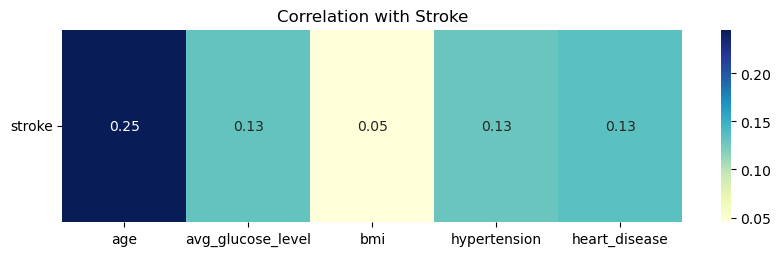

In [214]:
numeric_cols = ['age','avg_glucose_level','bmi','hypertension','heart_disease','stroke']
stroke_corr = df_clean[numeric_cols].corr()['stroke'].drop('stroke')
plt.figure(figsize=(10, 2.5))
sns.heatmap(stroke_corr.to_frame().T, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Correlation with Stroke")
plt.yticks(rotation=0)

In [215]:
categorical_analysis = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
fig = make_subplots(
    rows=2, cols=3,
    subplot_titles=[f'<b>Stroke Rate by {col.replace("_", " ").title()}</b>'
                    for col in categorical_analysis],
    specs=[[{'type': 'bar'}] * 3] * 2,
    vertical_spacing=0.15,
    horizontal_spacing=0.1
)
positions = [(1,1), (1,2), (1,3), (2,1), (2,2)]
for i, (col, pos) in enumerate(zip(categorical_analysis, positions)):
    stroke_rate = df_clean.groupby(col)['stroke'].agg(['sum', 'count'])
    stroke_rate['rate'] = (stroke_rate['sum'] / stroke_rate['count'] * 100)
    fig.add_trace(
        go.Bar(
            x=stroke_rate.index.astype(str),
            y=stroke_rate['rate'],
            marker_color=COLOR_PALETTE['danger'],
            text=np.round(stroke_rate['rate'], 2),
            texttemplate='%{text:.1f}%',
            textposition='auto',
            showlegend=False
        ),
        row=pos[0], col=pos[1]
    )
fig.update_layout(
    title=dict(text='<b>Stroke Rate Analysis Across Categories</b>',
               font=dict(size=26, color=COLOR_PALETTE['dark'])),
    height=1000
)


In [216]:
df_clean['age_group'] = pd.cut(df_clean['age'],
                                bins=[0, 20, 30, 40, 50, 60, 70, 100],
                                labels=['0-20', '21-30', '31-40', '41-50', '51-60', '61-70', '70+'])
age_stroke = df_clean.groupby('age_group')['stroke'].agg(['sum', 'count'])
age_stroke['rate'] = (age_stroke['sum'] / age_stroke['count'] * 100)
fig = make_subplots(specs=[[{"secondary_y": True}]], subplot_titles=['<b>Stroke Rate and Count by Age Group</b>'])
fig.add_trace(
    go.Bar(
        x=age_stroke.index.astype(str),
        y=age_stroke['count'],
        name='Total Patients',
        marker_color=COLOR_PALETTE['info'],
        opacity=0.6
    ),
    secondary_y=False
)
fig.add_trace(
    go.Scatter(
        x=age_stroke.index.astype(str),
        y=age_stroke['rate'],
        name='Stroke Rate (%)',
        marker_color=COLOR_PALETTE['danger'],
        line=dict(width=3),
        mode='lines+markers',
        marker=dict(size=8)
    ),
    secondary_y=True
)
fig.update_layout(title=dict(text='<b>Age Groups: Patient Count and Stroke Rate</b>',
                             font=dict(size=26, color=COLOR_PALETTE['dark'])), height=700)

/tmp/ipykernel_168423/2000683564.py:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [217]:
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=['<b>Stroke Rate by Gender</b>', '<b>Average Age by Gender</b>',
                    '<b>Average Glucose by Gender</b>', '<b>Average BMI by Gender</b>'],
)
gender_stroke = df_clean.groupby('gender')['stroke'].agg(['sum', 'count'])
gender_stroke['rate'] = (gender_stroke['sum'] / gender_stroke['count'] * 100)
fig.add_trace(
    go.Bar(
        x=gender_stroke.index,
        y=gender_stroke['rate'],
        marker_color=COLOR_PALETTE['danger'],
        text=np.round(gender_stroke['rate'], 2),
        texttemplate='%{text:.1f}%',
        textposition='auto',
        showlegend=False
    ),
    row=1, col=1
)
metrics = [('age', 2, 1, COLOR_PALETTE['primary']),
           ('avg_glucose_level', 2, 2, COLOR_PALETTE['secondary']),
           ('bmi', 2, 2, COLOR_PALETTE['accent'])]
positions = [(1, 2), (2, 1), (2, 2)]
for (metric, _, _, color), pos in zip(metrics, positions):
    gender_avg = df_clean.groupby('gender')[metric].mean()
    fig.add_trace(
        go.Bar(
            x=gender_avg.index,
            y=gender_avg.values,
            marker_color=color,
            text=np.round(gender_avg.values, 2),
            texttemplate='%{text:.1f}',
            textposition='auto',
            showlegend=False
        ),
        row=pos[0], col=pos[1]
    )
fig.update_layout(title=dict(text='<b>Gender-Based Health Metrics Analysis</b>',
                             font=dict(size=26, color=COLOR_PALETTE['dark'])), height=900)

In [218]:
smoking_stroke = df_clean.groupby('smoking_status').agg({
    'stroke': ['sum', 'count', lambda x: (x.sum() / len(x) * 100)],
    'age': 'mean',
    'avg_glucose_level': 'mean',
    'bmi': 'mean'
}).round(2)
smoking_stroke.columns = ['stroke_count', 'total_count', 'stroke_rate', 'avg_age', 'avg_glucose', 'avg_bmi']
smoking_stroke = smoking_stroke.reset_index()
fig = go.Figure()
fig.add_trace(go.Bar(
    name='Stroke Rate (%)',
    x=smoking_stroke['smoking_status'],
    y=smoking_stroke['stroke_rate'],
    marker_color=COLOR_PALETTE['danger'],
    text=smoking_stroke['stroke_rate'],
    texttemplate='%{text:.1f}%',
    textposition='auto',
    yaxis='y'
))
fig.update_layout(
    title=dict(text='<b>Stroke Rate by Smoking Status</b>', font=dict(size=26, color=COLOR_PALETTE['dark'])),
    height=700
)

In [219]:
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=['<b>Age Distribution by Stroke Status</b>', '<b>Comorbidity Combination Impact</b>',
                    '<b>Work Type Stroke Distribution</b>', None],
    specs=[[{'type': 'histogram'}, {'type': 'bar'}],
           [{'type': 'bar'}, {'type': 'bar'}]],
    vertical_spacing=0.15,
    horizontal_spacing=0.12
)
for stroke_val, color, name in zip([0, 1],
                                   [COLOR_PALETTE['info'], COLOR_PALETTE['danger']],
                                   ['No Stroke', 'Stroke']):
    fig.add_trace(
        go.Histogram(
            x=df_clean[df_clean['stroke'] == stroke_val]['age'],
            name=name,
            marker_color=color,
            opacity=0.7,
            showlegend=True
        ),
        row=1, col=1
    )
df_clean['risk_group'] = 'No Hypertension or Heart Disease'
df_clean.loc[df_clean['hypertension'] == 1, 'risk_group'] = 'Hypertension Only'
df_clean.loc[df_clean['heart_disease'] == 1, 'risk_group'] = 'Heart Disease Only'
df_clean.loc[(df_clean['hypertension'] == 1) & (df_clean['heart_disease'] == 1), 'risk_group'] = 'Hypertension & Heart Disease'
risk_colors = {
    'No Hypertension or Heart Disease': COLOR_PALETTE['info'],
    'Hypertension Only': COLOR_PALETTE['warning'],
    'Heart Disease Only': COLOR_PALETTE['warning'],
    'Hypertension & Heart Disease': COLOR_PALETTE['danger']
}
comorbid_stroke = df_clean.groupby('risk_group')['stroke'].agg(['sum', 'count'])
comorbid_stroke['rate'] = (comorbid_stroke['sum'] / comorbid_stroke['count'] * 100)
fig.add_trace(
    go.Bar(
        x=comorbid_stroke.index,
        y=comorbid_stroke['rate'],
        marker_color=[risk_colors[x] for x in comorbid_stroke.index],
        text=np.round(comorbid_stroke['rate'], 2),
        texttemplate='%{text:.1f}%',
        textposition='auto',
        showlegend=False
    ),
    row=1, col=2
)
work_stroke = df_clean.groupby('work_type')['stroke'].sum().sort_values(ascending=False)
fig.add_trace(
    go.Bar(
        x=work_stroke.index,
        y=work_stroke.values,
        marker_color=COLOR_PALETTE['secondary'],
        text=work_stroke.values,
        textposition='auto',
        showlegend=False
    ),
    row=2, col=1
)
fig.update_layout(
    title=dict(text='<b>Stroke Risk Dashboard (Simplified)</b>', font=dict(size=28, color=COLOR_PALETTE['dark'])),
    height=1000
)

In [220]:
df_clean['bmi_class'] = pd.cut(df_clean['bmi'], bins=[0, 18.5, 24.9, 29.9, 100], labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
stroke_rate = df_clean.groupby('bmi_class')['stroke'].mean() * 100
fig = go.Figure([go.Bar(x=stroke_rate.index, y=stroke_rate.values, marker_color=COLOR_PALETTE['danger'])])
fig.update_layout(title='Stroke Rate by BMI Class', yaxis_title='Stroke Rate (%)')
fig.show()

/tmp/ipykernel_168423/1192037597.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [221]:
# New features 
df_clean['cardiovascular_risk_score'] = df_clean['hypertension'] + df_clean['heart_disease']
df_clean['age_bmi_interaction'] = df_clean['age'] * df_clean['bmi']
df_clean['glucose_risk'] = pd.cut(df_clean['avg_glucose_level'], bins=[0, 140, 200, 300], labels=['Normal', 'Prediabetes', 'Diabetes'])

stroke_rate = df_clean.groupby('cardiovascular_risk_score')['stroke'].mean() * 100
fig = go.Figure([go.Bar(x=stroke_rate.index, y=stroke_rate.values, marker_color=COLOR_PALETTE['danger'])])
fig.update_layout(title='Stroke Rate by Cardiovascular Risk Score', yaxis_title='Stroke Rate (%)')
fig.show()

In [222]:
stroke_rate = df_clean.groupby(['bmi_class','glucose_risk'])['stroke'].mean().unstack() * 100
fig = go.Figure()
for col in stroke_rate.columns:
    fig.add_trace(go.Bar(x=stroke_rate.index, y=stroke_rate[col], name=col))
fig.update_layout(title='Stroke Rate by BMI Class & Glucose Risk', yaxis_title='Stroke Rate (%)', barmode='group')
fig.show()


/tmp/ipykernel_168423/1306213625.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [223]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=df_clean['cardiovascular_risk_score'], nbinsx=3, marker_color=COLOR_PALETTE['primary']))
fig.update_layout(title='Distribution of Cardiovascular Risk Score', xaxis_title='Score', yaxis_title='Count')
fig.show()